In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
args = {}
args['dim_h'] = 10            # factor controlling size of hidden layers
args['n_channel'] = 1         # number of channels in the input data (MNIST is 1, aka greyscale)
args['n_z'] = 5               # number of dimensions in latent space. -- might need to bump this up? not sure what's common for MNIST
args['sigma'] = 1.0           # variance in n_z
args['lambda'] = 10           # hyper param for weight of discriminator loss
args['lr'] = 0.0001           # learning rate for Adam optimizer
args['epochs'] = 10           # how many epochs to run for
args['batch_size'] = 256      # batch size for SGD

In [3]:
## load MNIST data train and test sets
trainset = datasets.MNIST(
    root='./data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

testset = datasets.MNIST(
    root='./data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

train_loader = DataLoader(
    dataset=trainset,
    batch_size=args['batch_size'],
    shuffle=True
)

test_loader = DataLoader(
    dataset=testset,
    batch_size=args['batch_size'],
    shuffle=False
)

Processing...
Done!


## Try out the vanilla autoencoder 

In [4]:
## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

In [5]:
# instantiate models, and set to train mode
encoder, decoder = Encoder(args), Decoder(args)
encoder.train()
decoder.train()

# specify loss (mean squared error of image reconstruction)
criterion = nn.MSELoss()

# use the Adam optimizer, it's always a good choice
enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

In [6]:
for epoch in range(args['epochs']):
    step = 0

    for images, _ in tqdm(train_loader):
        encoder.zero_grad()
        decoder.zero_grad()
        batch_size = images.size()[0]

        z_real = encoder(images)
        x_recon = decoder(z_real)
        recon_loss = criterion(x_recon, images)

        recon_loss.backward()
        
        enc_optim.step()
        dec_optim.step()
        
        step += 1

        if (step + 1) % 100 == 0:
            print("Epoch: [%d/%d], Step: [%d/%d], Reconstruction Loss: %.4f" %
                  (epoch + 1, args['epochs'], step + 1, len(train_loader), recon_loss.data.item()))
            

 42%|████▏     | 99/235 [00:36<00:48,  2.81it/s]

Epoch: [1/5], Step: [100/235], Reconstruction Loss: 0.2040


 85%|████████▍ | 199/235 [01:12<00:12,  2.85it/s]

Epoch: [1/5], Step: [200/235], Reconstruction Loss: 0.1672


 42%|████▏     | 99/235 [00:34<00:46,  2.93it/s]

Epoch: [2/5], Step: [100/235], Reconstruction Loss: 0.1276


 85%|████████▍ | 199/235 [01:09<00:11,  3.08it/s]

Epoch: [2/5], Step: [200/235], Reconstruction Loss: 0.1054


 42%|████▏     | 99/235 [00:33<00:48,  2.80it/s]

Epoch: [3/5], Step: [100/235], Reconstruction Loss: 0.0842


 85%|████████▍ | 199/235 [01:12<00:13,  2.74it/s]

Epoch: [3/5], Step: [200/235], Reconstruction Loss: 0.0731


 42%|████▏     | 99/235 [00:36<00:42,  3.22it/s]

Epoch: [4/5], Step: [100/235], Reconstruction Loss: 0.0621


 85%|████████▍ | 199/235 [01:07<00:12,  2.87it/s]

Epoch: [4/5], Step: [200/235], Reconstruction Loss: 0.0583


 42%|████▏     | 99/235 [00:36<00:51,  2.66it/s]

Epoch: [5/5], Step: [100/235], Reconstruction Loss: 0.0525


 85%|████████▍ | 199/235 [01:13<00:11,  3.15it/s]

Epoch: [5/5], Step: [200/235], Reconstruction Loss: 0.0485


100%|██████████| 235/235 [01:25<00:00,  3.64it/s]


## Let's look at some images

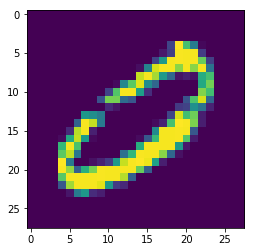

In [9]:
# look at an original image
plt.imshow(images[2,0].numpy())

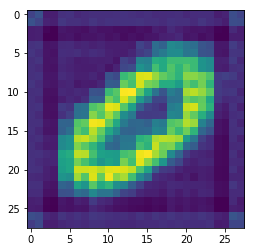

In [10]:
# run same image through autoencoder and take a peak
z_reps = encoder(images)
decoded_images = decoder(z_reps)

plt.imshow(decoded_images[2,0].detach().numpy())

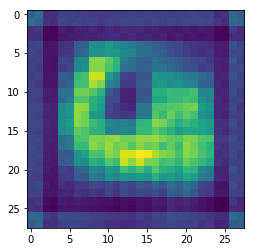

In [11]:
# try a random sample of the latent space
rand_z_reps = torch.randn_like(z_reps)
rand_decoded_images = decoder(rand_z_reps)

plt.imshow(rand_decoded_images[2,0].detach().numpy())

## WAE-GAN!

In [13]:
# define the descriminator
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # main body of discriminator, returns [0,1]
        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x
    
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [14]:
# instantiate discriminator model, and restart encoder and decoder, for fairness. Set to train mode, etc
encoder, decoder, discriminator = Encoder(args), Decoder(args), Discriminator(args)
encoder.train()
decoder.train()
discriminator.train()

enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])
dis_optim = torch.optim.Adam(discriminator.parameters(), lr = args['lr'])

In [ ]:
one = torch.Tensor([1])

for epoch in range(args['epochs']):
    step = 0

    for images, _ in tqdm(train_loader):
        encoder.zero_grad()
        decoder.zero_grad()
        discriminator.zero_grad()

        # ======== Train Discriminator ======== #
        
        # freeze auto encoder params
        frozen_params(decoder)
        frozen_params(encoder)
        
        # free discriminator params
        free_params(discriminator)

        # run discriminator against randn draws
        z_fake = torch.randn(images.size()[0], args['n_z']) * args['sigma']
        d_fake = discriminator(z_fake)

        # run discriminator against encoder z's
        z_real = encoder(images)
        d_real = discriminator(z_real)

        # formula for ascending the descriminator -- -one reverses the direction of the gradient.
        torch.log(d_fake).mean().backward(-one)
        torch.log(1 - d_real).mean().backward(-one)

        dis_optim.step()

        # ======== Train Generator ======== #

        # flip whose frozen, whose not
        free_params(decoder)
        free_params(encoder)
        frozen_params(discriminator)

        batch_size = images.size()[0]

        # run images
        z_real = encoder(images)
        x_recon = decoder(z_real)
        
        # discriminate latents
        d_real = discriminator(encoder(images.data))

        # calculate reconstruction loss
        recon_loss = criterion(x_recon, images)
        
        # calculate discriminator loss
        d_loss = args['lambda'] * (torch.log(d_real)).mean()

        recon_loss.backward(one)
        d_loss.backward(-one)

        enc_optim.step()
        dec_optim.step()

        step += 1

        if (step + 1) % 100 == 0:
            print("Epoch: [%d/%d], Step: [%d/%d], Reconstruction Loss: %.4f" %
                (epoch + 1, args['epochs'], step + 1, len(train_loader), recon_loss.data.item()))

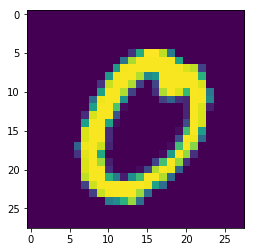

In [88]:
# look at an original image
plt.imshow(images[0,0].numpy())

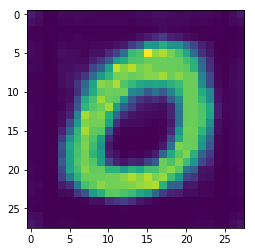

In [89]:
# run same image through autoencoder and take a peak
z_reps = encoder(images)
decoded_images = decoder(z_reps)

plt.imshow(decoded_images[0,0].detach().numpy())

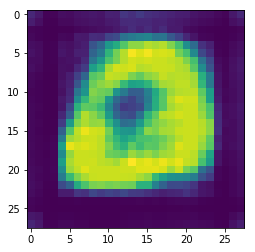

In [95]:
# try a random sample of the latent space
rand_z_reps = torch.randn_like(z_reps)
rand_decoded_images = decoder(rand_z_reps)

plt.imshow(rand_decoded_images[0,0].detach().numpy())